In [ ]:
# Libraries
import os
import numpy as np
!conda install --yes pandas 
!conda install --yes -c conda-forge ipywidgets
import pandas as pd

import cv2
!conda install --yes seaborn 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import gc
import time
import copy
from tqdm import tqdm
from sklearn.utils import compute_class_weight
from PIL import Image
import math
from glob import glob


Hyper parameters and device configuration

In [ ]:
# Hyper parameters
NUM_CLASSES = 2 # Labels: 0 - Non IDC, 1 - IDC
BATCH_SIZE = 64

# CNN
NUM_EPOCHS_CNN = 1
#BATCH_SIZE_CNN  = 128
learning_rate_CNN = 0.002

# Resnet
NUM_EPOCHS_RESNET = 1
#BATCH_SIZE_RESNET  = 128
learning_rate_RESNET  = 0.002
learning_rate_RESNET2 = 0.002
run_training = True
retrain = False
find_learning_rate = True

# DensNet
learning_rate_DensNet  = 0.002
NUM_EPOCHS_DENSNET = 1

In [15]:
# Device configuration
#torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'Quadro M4000'

Read the data (images) and create a csv file, dataset object and data loaders

In [16]:
x=[] # x coordinate of an image
SelectedImageData = [] # For the csv and the dataloaders
y=[] # y coordinate of an image
ID=[] # ID of a patient
cl=[] # class (0 for non IDC, 1 for IDC)
target=[] # class
matrix = [] # All the image data
i = 0
imagePatches = glob('../IDC_regular_ps50_idx5/**/*.png', recursive=True)
print("ImagePatches length (Total number of images): ", len(imagePatches))
print("imagePatches[0] (Checking if we read the file name): ", imagePatches[0])

# Go over all the images and create a dataset csv file including: x coordinate, y coordinate, target(label: 0-non IDC, 1-IDC), ID - Patient ID
for img in imagePatches:
    # For each image path extract the data from the image name
    imagePatches1=imagePatches[i].split("/")
    imagePatches2=imagePatches1[-1].split("_")
    x=imagePatches2[2].split("x")
    x=x[1]
    y=imagePatches2[3].split("y")
    y=y[1]
    target=imagePatches2[4].split(".png")
    cl=target[0]
   
    if cl=='class0':
        cl=0
    elif cl=='class1':
         cl=1
    ID=imagePatches2[0]
    filename=imagePatches[i]
    SelectedImageData = [ID,x,y,filename,cl]
    column_names = ["patient_id","x","y","filename","target"]
    matrix.append(SelectedImageData)
    i=i+1

ImagePatches length (Total number of images):  277524
imagePatches[0] (Checking if we read the file name):  ../IDC_regular_ps50_idx5/12910/1/12910_idx5_x651_y201_class1.png


In [17]:
base_path = "../IDC_regular_ps50_idx5/"
folder = os.listdir(base_path)

# Add fully defined column into the row
images_df = pd.DataFrame(matrix, columns = column_names)

In [18]:
print("Create csv file")
# Create the dataset csv
images_df.to_csv(r'dataset.csv', index = False) 

Create csv file


In [19]:
files = os.listdir("../IDC_regular_ps50_idx5/")
print("Number of folders (Patients): ", len(files))

Number of folders (Patients):  279


In [20]:
# read csv file and return the created dataset (cancer_perc - precent of cancer images per patinet)
dataset = pd.read_csv("dataset.csv", usecols=['patient_id', 'filename','target'])
cancer_perc = dataset.groupby("patient_id").target.value_counts()/ dataset.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()
print("cancer_perc:" ,cancer_perc)

cancer_perc: target             0         1
patient_id                    
8863        0.788560  0.211440
8864        0.710503  0.289497
8865        0.922753  0.077247
8867        0.901340  0.098660
8913        0.914136  0.085864
...              ...       ...
16568       0.658213  0.341787
16569       0.896142  0.103858
16570       0.408942  0.591058
16895       0.761589  0.238411
16896       0.902396  0.097604

[279 rows x 2 columns]


In [29]:
#Splitting data into train and test: 0.2 for test 0.8 for train
train, test = train_test_split(images_df, stratify=images_df.target, test_size=0.2,train_size=0.8)
print("Train length: %d Test length %d" %(len(train), len(test)))
print("\nTrain head: ", train.head())
print("\nTest head: ", test.head())

Train length: 222019 Test length 55505

Train head:         patient_id     x     y  \
204907       9258   551  2151   
186530      10258   701  1051   
114309       9178   151  1501   
216528      12752  2351  1301   
142386       9320  2501  1501   

                                                 filename  target  
204907  ../IDC_regular_ps50_idx5/9258/0/9258_idx5_x551...       0  
186530  ../IDC_regular_ps50_idx5/10258/0/10258_idx5_x7...       0  
114309  ../IDC_regular_ps50_idx5/9178/0/9178_idx5_x151...       0  
216528  ../IDC_regular_ps50_idx5/12752/0/12752_idx5_x2...       0  
142386  ../IDC_regular_ps50_idx5/9320/0/9320_idx5_x250...       0  

Test head:         patient_id     x     y  \
143793      10273   951   551   
238083      12955   501   251   
90905        9259  2401   901   
121510      16550  2501  1701   
106290      10279   201  2201   

                                                 filename  target  
143793  ../IDC_regular_ps50_idx5/10273/1/10273_idx5_x9...   

In [30]:
train = train[["filename","target"]]
test = test[["filename","target"]]
print("Train head: ", train.head())
print("\nTest head: ", test.head())

Train head:                                                   filename  target
204907  ../IDC_regular_ps50_idx5/9258/0/9258_idx5_x551...       0
186530  ../IDC_regular_ps50_idx5/10258/0/10258_idx5_x7...       0
114309  ../IDC_regular_ps50_idx5/9178/0/9178_idx5_x151...       0
216528  ../IDC_regular_ps50_idx5/12752/0/12752_idx5_x2...       0
142386  ../IDC_regular_ps50_idx5/9320/0/9320_idx5_x250...       0

Test head:                                                   filename  target
143793  ../IDC_regular_ps50_idx5/10273/1/10273_idx5_x9...       1
238083  ../IDC_regular_ps50_idx5/12955/0/12955_idx5_x5...       0
90905   ../IDC_regular_ps50_idx5/9259/0/9259_idx5_x240...       0
121510  ../IDC_regular_ps50_idx5/16550/1/16550_idx5_x2...       1
106290  ../IDC_regular_ps50_idx5/10279/0/10279_idx5_x2...       0


In [31]:
class MyDataset(Dataset):
    def __init__(self, df_data,transform=None):
        super().__init__()
        self.df = df_data.values
        
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path,label = self.df[index]
        
        image = cv2.imread(img_path)
        image = cv2.resize(image, (50,50))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [32]:
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.RandomHorizontalFlip(), 
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomRotation(20), 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_test = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [33]:
dataset_train = MyDataset(df_data = train, transform=trans_train)
dataset_test = MyDataset(df_data = test,transform=trans_test)

In [34]:
loader_train = DataLoader(dataset_train, batch_size = BATCH_SIZE, shuffle = True, drop_last=True, num_workers=0)
loader_test = DataLoader(dataset = dataset_test, batch_size = BATCH_SIZE//2, shuffle=False, num_workers=0)

print("Interaction for train and test:")
print(len(loader_train), len(loader_test))

Interaction for train and test:
3469 1735


In [40]:
# Train the model
def train_model(NUM_EPOCHS, loader_train, optimizer, criterion, model, ModelCheckPointName, loss_acc = 100):
    print("Train started:")
    model.to(device)
    #model_Cnn.to(device)
    #criterion = nn.CrossEntropyLoss()
    # Loss and optimizer
    #optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
    loss_array=[]
    x=[]
    #Epoch_time=0
    #Int100_time=0
    #Int100_time1=np.zeros(1735) 
    total_step = len(loader_train)
    test_loss , test_accuracy = [], []
    start = time.time()
    curr_time = 0
    running_loss = 0
    for epoch in range(NUM_EPOCHS):
        torch.cuda.synchronize()
    
        tk0 = tqdm(loader_train, total=int(len(loader_train)),desc= "Progress: ")
        
        for i, (filename, target) in enumerate(tk0):
            
            filename = filename.to(device)
            target = target.to(device)
        
            # Forward pass
            #torch.cuda.empty_cache()        
            outputs = model(filename)
            loss = criterion(outputs, target)
            running_loss += loss.item()
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Finished loss_acc iterations
            if(i+1) % loss_acc == 0:
                torch.cuda.synchronize()
                #stop = time.time()
                #time_diff = stop-start
                loss_array.append(running_loss / i) 
                running_loss = 0
        
            # Finished an epoch
            elif (i+1) % len(loader_train) == 0:
                torch.cuda.synchronize()
                #stop = time.time()
                #time_diff = stop - start
                #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, time:{} min' 
                 #          .format(epoch+1, NUM_EPOCHS, i+1, total_step, loss.item(),time_diff/60))
                                
                # Save the model checkpoint
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_array': loss_array,
                }, 'models/Model_' + ModelCheckPointName + '.pth')
                  
                #torch.save(model.state_dict(), 'models/model_res.ckpt')
                """
                if (epoch+1) % NUM_EPOCHS == 0:
                                      
                    Test_acc =Test_model(model)
                   
                    print ('All_Epochs [{}],Loss: {:.4f},Test_accuracy:{} %,Epoch_total_time:{} min' 
                   .format(NUM_EPOCHS,loss.item(),Test_acc,curr_time/60))
                    # Save the model checkpoint
                    torch.save(model.state_dict(), 'models/model_res.ckpt')
                    
                else:
                        torch.cuda.synchronize()
                        print ('Epoch [{}],Loss: {:.4f},Epoch_time:{} min' 
                                 .format(epoch+1,loss.item(),Epoch_time))
                        loss_array.append(loss.item())

    # save model checkpoint
    torch.save({
            'epoch': NUM_EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            'Accurcy':Test_acc
            }, '../DeepLearningProjectNew/models/model.pth')
   """
    #print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, time:{} min' 
     #      .format(epoch+1, NUM_EPOCHS, i+1, total_step, loss.item(),time_diff/60)) 
    stop = time.time()
    time_diff = stop-start
    total_time = time_diff/60
    return loss_array, total_time

In [74]:
# Test the model
def Test_model(model_Cnn):
    print("Test started:")
    model_Cnn.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    confusion_matrix = torch.zeros(2, 2)
    with torch.no_grad():
        correct = 0
        total = 0
        tk0 = tqdm(loader_test, total=int(len(loader_test)),desc= "Progress: ")
        for filename, target in tk0:
            filename = filename.to(device)
            target = target.to(device)
            outputs = model_Cnn(filename)               
            temp, predicted = torch.max(outputs.data, 1)               
            total += target.size(0)
            correct += (predicted == target).sum().item()
            for t, p in zip(target.view(-1), predicted.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1                    
        Test_acc =format(100 * correct / total)
    #print(confusion_matrix)    
    return Test_acc, confusion_matrix   

In [43]:
# Test the model
def plots(loss_array, ModelName):
    """
    # accuracy plots
    plt.figure(figsize = (10, 7))
    plt.plot(Test_acc, color = 'green', label = 'test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('../DeepLearningProjectNew/models/test accuracy.png')
    plt.show()
    """
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(loss_array, color = 'orange', label = 'Train Loss - '+ ModelName)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('models/Model_' + ModelName + '_Loss.png')
    plt.show()

In [44]:
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)            
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * 1 * 1, 2)
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))   
        x = self.avg(x)
        #print(x.shape) # to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [45]:
# Create the model
model_Cnn = SimpleCNN()
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adamax(model_Cnn.parameters(), lr = learning_rate_CNN)

In [47]:
# Train the model
loss_array_cnn, total_time = train_model(NUM_EPOCHS_CNN,loader_train, optimizer_cnn,criterion_cnn,model_Cnn,"Model_Cnn",loss_acc = 50)

Train started:


Progress: 100%|██████████| 3469/3469 [44:34<00:00,  1.30it/s]


Test started:


Progress: 100%|██████████| 1735/1735 [09:55<00:00,  2.91it/s]


Total time for training:  44.57188174724579
confusion_matrix:  tensor([[36989.,  2759.],
        [ 4009., 11748.]])
All_Epochs [1],Test_accuracy:87.8065039185659


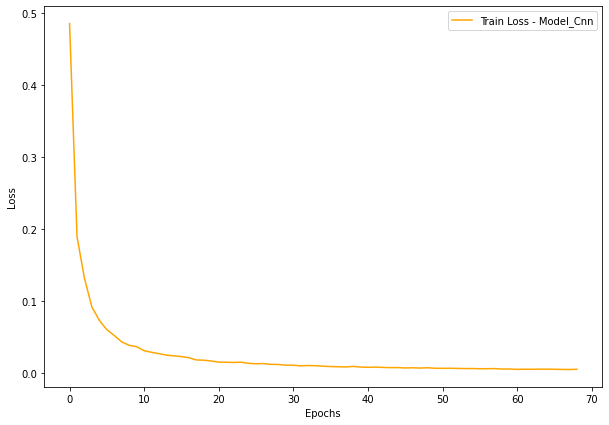

In [49]:
Test_acc, confusion_matrix = Test_model(model_Cnn)
print("Total time for training: ", total_time)
print("confusion_matrix: ", confusion_matrix)
print ('All_Epochs [{}],Test_accuracy:{}'.format(NUM_EPOCHS_CNN,Test_acc))
plots(loss_array_cnn, "Model_Cnn") # loss plots

End of CNN Module

Start of Resnet Module

In [50]:
def weights(device,train_df):    
    weights = compute_class_weight(y=train_df.target.values, class_weight = "balanced", classes = train_df.target.unique())    
    class_weights = torch.FloatTensor(weights)
    if device.type == "cuda":
        class_weights = class_weights.cuda()
    print(class_weights)
    train_df.target.unique()
    return class_weights

In [51]:
model_resnet = torchvision.models.resnet18(pretrained=False)
#if run_training:
#    model.load_state_dict(torch.load("../input/pretrained-pytorch-models/resnet18-5c106cde.pth"))
num_features = model_resnet.fc.in_features
print(num_features)

model_resnet.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    
    nn.Linear(256, NUM_CLASSES))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model_resnet.apply(init_weights)
model_resnet = model_resnet.to(device)

512


In [52]:
class_weights = weights(device,train)
print("class_weights:\n", class_weights)
criterion_resnet = nn.CrossEntropyLoss(weight=class_weights)
optimizer_resnet = torch.optim.Adamax(model_resnet.fc.parameters(), lr = learning_rate_RESNET) #, end_lr)#torch.optim.SGD(model.fc.parameters(), start_lr)

tensor([0.6982, 1.7612], device='cuda:0')
class_weights:
 tensor([0.6982, 1.7612], device='cuda:0')


In [53]:
loss_array_RESNET, total_time = train_model(NUM_EPOCHS_RESNET,loader_train,optimizer_resnet,criterion_resnet,model_resnet, "Model_Resnet",loss_acc = 50)

Train started:


Progress: 100%|██████████| 3469/3469 [44:07<00:00,  1.31it/s]


Test started:


Progress: 100%|██████████| 1735/1735 [09:43<00:00,  2.97it/s]


Total time for training:  44.130254650115965
82.745698585713
tensor([[34129.,  5619.],
        [ 3958., 11799.]])


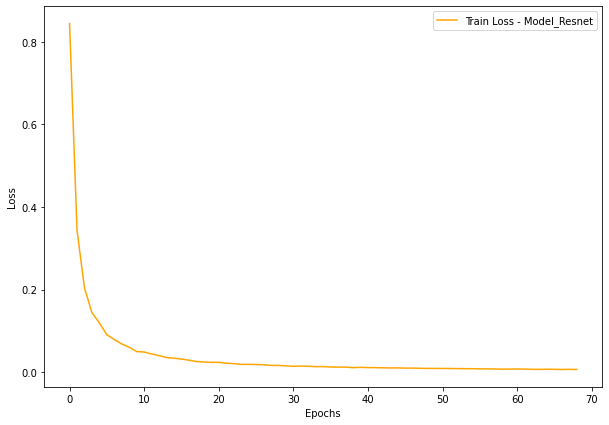

In [54]:
Test_acc, confusion_matrix = Test_model(model_resnet)
print("Total time for training: ", total_time)
print(Test_acc)
print(confusion_matrix)
plots(loss_array_RESNET, "Model_Resnet") # loss plots

Start of Resnet2 Module (Resnet34)

In [55]:
model_resnet2 = torchvision.models.resnet34(pretrained=False)
model_resnet2 = model_resnet2.to(device)

In [56]:
# Create resnet model
#model_resnet2 = model50(NUM_CLASSES)

In [59]:
#class_weights2 = weights(device,train)
#print(class_weights2)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adamax(model_resnet2.fc.parameters(), lr = learning_rate_RESNET2) #, end_lr)#torch.optim.SGD(model.fc.parameters(), start_lr)

In [60]:
loss_array_RESNET2, total_time = train_model(NUM_EPOCHS_RESNET,loader_train,optimizer2,criterion2,model_resnet2,"Model_Resnet2",loss_acc=50)

Train started:


Progress: 100%|██████████| 3469/3469 [45:41<00:00,  1.27it/s]


Test started:


Progress: 100%|██████████| 1735/1735 [10:59<00:00,  2.63it/s]


Total time for training:  45.693631919225055
81.6557066930907
tensor([[34919.,  4829.],
        [ 5353., 10404.]])


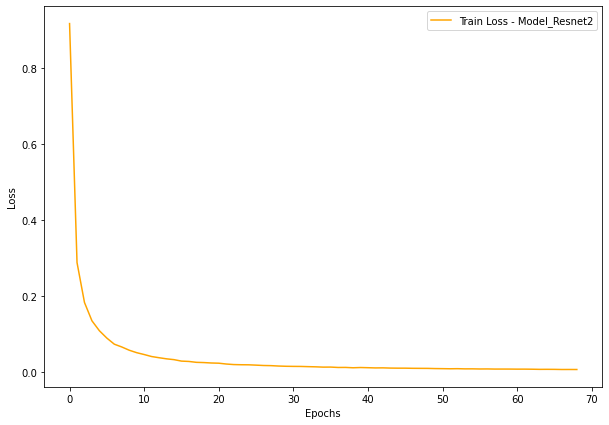

In [61]:
Test_acc, confusion_matrix = Test_model(model_resnet2)
print("Total time for training: ", total_time)
print(Test_acc)
print(confusion_matrix)
plots(loss_array_RESNET2, "Model_Resnet2") # loss plots

End of Resnet2 Module

Start model DensNet

In [62]:
class DensNet(nn.Module):
    def __init__(self, num_classes=1000, num_channels=3):
        super().__init__()
        preloaded = torchvision.models.densenet121(pretrained=True)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)
        self.classifier = nn.Linear(1024, num_classes, bias=True)
        del preloaded
        
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [79]:
model_DensNet = DensNet(num_classes=NUM_CLASSES)
model_DensNet.to(device);

Exception ignored in: <function tqdm.__del__ at 0x7fe9c58d4b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/opt/conda/lib/python3.8/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
optimizer_DensNet = torch.optim.Adam(model_DensNet.parameters(), learning_rate_DensNet)
criterion_DensNet = nn.CrossEntropyLoss()

In [ ]:
loss_array_DensNet, total_time = train_model(NUM_EPOCHS_DENSNET,loader_train, optimizer_DensNet,criterion_DensNet,model_DensNet,"Model_DensNet")

In [ ]:
Test_acc, confusion_matrix = Test_model(model_DensNet)
print("Total time for training: ", total_time)
print("confusion_matrix: ", confusion_matrix)
print ('All_Epochs [{}],Test_accuracy:{}'.format(NUM_EPOCHS_DENSNET,Test_acc))
plots(loss_array_DensNet, "Model_DensNet") # loss plots

In [ ]:
class SimpleCNN2(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)            
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
        
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))   
        x = self.avg(x)
        #print(x.shape) # to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [ ]:
# model_Cnn, model_resnet, model_resnet2, model_DensNet


In [81]:
# Test the model by majority vote
def Test_model_majority_vote(model_resnet, model_resnet2, model_Cnn):
    model_Cnn.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    confusion_matrix = torch.zeros(2, 2)
    with torch.no_grad():
        correct = 0
        total = 0
        #tk0 = tqdm(loader_test, total=int(len(loader_test)), desc= "Progress: ")
        for filename, target in loader_test:
            filename = filename.to(device)
            target = target.to(device)
            outputs_cnn = model_Cnn(filename)
            outputs_resnet = model_resnet(filename)
            outputs_resnet2 = model_resnet2(filename) 
            temp, predicted_cnn = torch.max(outputs_cnn.data, 1)
            temp, predicted_resnet = torch.max(outputs_resnet.data, 1) 
            temp, predicted_resnet2 = torch.max(outputs_resnet2.data, 1)
            predicted = torch.round((predicted_cnn + predicted_resnet + predicted_resnet2) / 3)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            for t, p in zip(target.view(-1), predicted.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1                    
        Test_acc =format(100 * correct / total)
    #print(confusion_matrix)    
    return Test_acc, confusion_matrix   


In [ ]:
Test_acc, confusion_matrix = Test_model_majority_vote(model_resnet, model_resnet2, model_Cnn)

In [ ]:
print(Test_acc)
print(confusion_matrix)